In [10]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import pandas as pd
from os import listdir
from os.path import isfile, join
import pymc3 as pm
import math as m
import arviz as az

import dive
import matplotlib.pyplot as plt
import deerlab as dl

from theano import tensor as T
from theano.tensor import nlinalg as tnp
from theano.tensor import slinalg as snp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Generate a synthetic distribution and calculate S

In [11]:
data, pars = dive.generateMultiGauss(nt = 160, seed = 129, k = 0.5, sigma = 0.01, V0 = 1.15, t_edges=[-0.1,3.0])

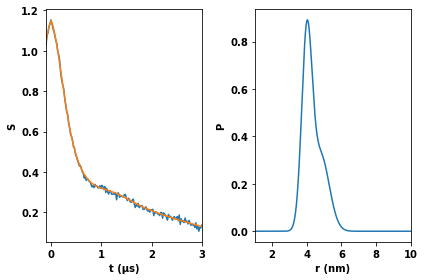

In [12]:
t = data['t']
Vexp = data['V']

fig, ax = plt.subplots(1,2)
line0 = ax[0].plot(t, Vexp)
line1 = ax[0].plot(t, data['V0'])
line2 = ax[1].plot(data['r'], data['P'])

ax[0].set(xlim = [min(t),max(t)], xlabel = 't (µs)', ylabel = 'S')
ax[1].set(xlim = [min(data['r']),max(data['r'])], xlabel = 'r (nm)', ylabel = 'P')
plt.tight_layout()
plt.show()

### Initialize parameters and matrices

-0.5583135272051312


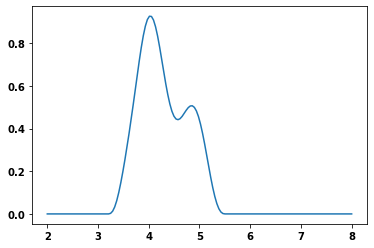

In [13]:
# r vector
r = np.linspace(2,8,150)
dr = r[1] - r[0]

fit = dl.fitmodel(Vexp,t,r,'P',dl.bg_exp,dl.ex_4pdeer)
plt.plot(r,fit.P)
print(np.log10(fit.regparam))

# kernel regularization operator
K0 = dl.dipolarkernel(t,r,integralop=False)   # kernel matrix
L = dl.regoperator(np.linspace(1,len(r),len(r)), 2)
LtL = np.matmul(np.transpose(L),L)
K0tK0 = np.matmul(np.transpose(K0),K0)

# parameters for delta distribution
a0 = 0.01
b0 = 1e-6

In [14]:
print(fit.exparam)
print(fit.bgparam)

[0.48461006]
[1.07898938]


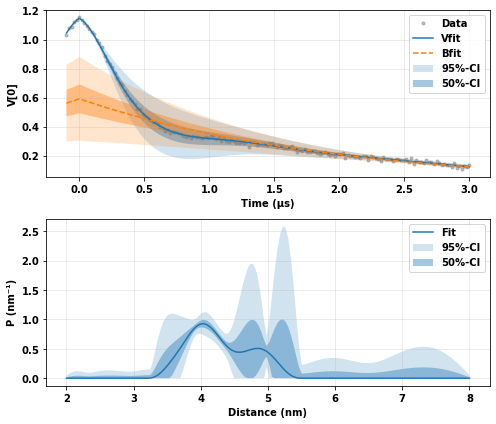

In [15]:
fit.plot();

### Setup model

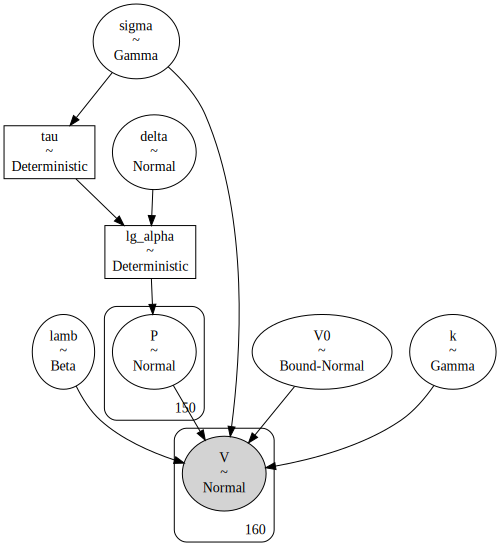

In [16]:
with pm.Model() as model:
    # Noise --------------------------------------------------------------
    sigma = pm.Gamma('sigma', alpha=0.7, beta=2)
    tau = pm.Deterministic('tau',1/(sigma**2))

    # Regularization parameter -------------------------------------------
    delta = pm.Normal('delta', mu = 20000, sigma = 10000)
    lg_alpha = pm.Deterministic('lg_alpha', np.log10(np.sqrt(delta/tau)) )
    
    # Time Domain --------------------------------------------------------
    lamb = pm.Beta('lamb', alpha=1.3, beta=2.0)
    V0 = pm.Bound(pm.Normal, lower=0.0)('V0', mu=1, sigma=0.2)

    # Background ---------------------------------------------------------
    k = pm.Gamma('k', alpha=0.5, beta=2)
    B = dl.bg_exp(t, k)

    # Distance distribution ----------------------------------------------
    # P = pm.MvNormal("P", mu = np.ones_like(r), tau = invSigma, shape = len(r))
    P = pm.Normal("P", mu = 1, sigma = lg_alpha, shape = len(r))      

    # Calculate matrices and operators -----------------------------------
    Kintra = (1-lamb) + lamb*K0
    B_ = T.transpose( T.tile(B,(len(r),1)) )
    K = V0*Kintra*B_*dr

    # Time domain model ---------------------------------------------------
    Vmodel = pm.math.dot(K,P)

    # Likelihood ----------------------------------------------------------
    pm.Normal('V',mu = Vmodel, sigma = sigma, observed = Vexp)

pm.model_to_graphviz(model) 

### Run sampler

In [9]:
with model:
    step_P = dive.SamplePfromV(P, K0, LtL, t, Vexp, r, delta, sigma, k, lamb, V0)
    step_delta = dive.randDelta(delta, a0, b0, L, P)
    trace = pm.sample(step = [step_P, step_delta], chains=1, cores=1, draws=500, tune= 500, return_inferencedata=False, progressbar = False)

Sequential sampling (1 chains in 1 job)
CompoundStep
>SamplePfromV: [P]
>randDelta: [delta]
>NUTS: [k, V0, lamb, sigma]
Step P    : k: -1.3862943611198906 V0 0.0 l -0.43078291609245406 s -1.0498221244986778 d 20000.0
Step delta: k: -1.3862943611198906 V0 0.0 l -0.43078291609245406 s -1.0498221244986778
Step P    : k: -1.3862943611198906 V0 0.0 l -0.43078291609245406 s -1.0498221244986778 d 20291.198293348178
Step delta: k: -1.3862943611198906 V0 0.0 l -0.43078291609245406 s -1.0498221244986778
Step P    : k: -1.3862943611198906 V0 0.0 l -0.43078291609245406 s -1.0498221244986778 d 12643.933175535247
Step delta: k: -1.3862943611198906 V0 0.0 l -0.43078291609245406 s -1.0498221244986778
Step P    : k: -1.2590175370744598 V0 -0.36805387064895473 l -0.34118055046648854 s -2.1572702425352763 d 8104.08532095084
Step delta: k: -1.2590175370744598 V0 -0.36805387064895473 l -0.34118055046648854 s -2.1572702425352763
Step P    : k: -1.3185712325713297 V0 -0.13663904379838715 l -0.382605931077242

AttributeError: partially initialized module 'aesara' has no attribute 'graph' (most likely due to a circular import)

### Analysis

mean         sd    hdi_3%    hdi_97%  mcse_mean   mcse_sd  \
k          0.340      0.157     0.006      0.490      0.073     0.055   
λ          0.641      0.107     0.516      0.846      0.048     0.037   
V₀         1.149      0.009     1.127      1.164      0.002     0.002   
σ          0.024      0.005     0.016      0.034      0.001     0.000   
δ      31493.296  17077.677  9684.406  61363.685   1897.316  1346.464   
lg(α)      0.601      0.060     0.486      0.724      0.005     0.004   

       ess_bulk  ess_tail  r_hat  
k           8.0      19.0   1.64  
λ           7.0      21.0   1.65  
V₀         14.0     121.0   1.22  
σ          76.0     106.0   1.08  
δ          77.0     181.0   1.05  
lg(α)     166.0      67.0   1.10

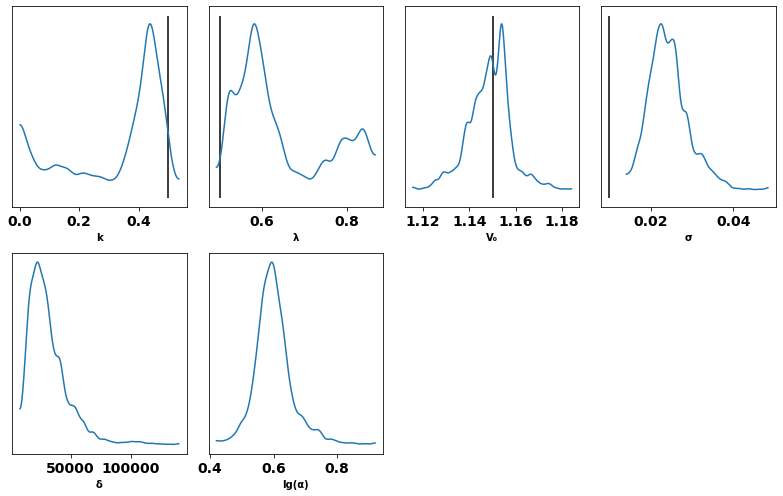

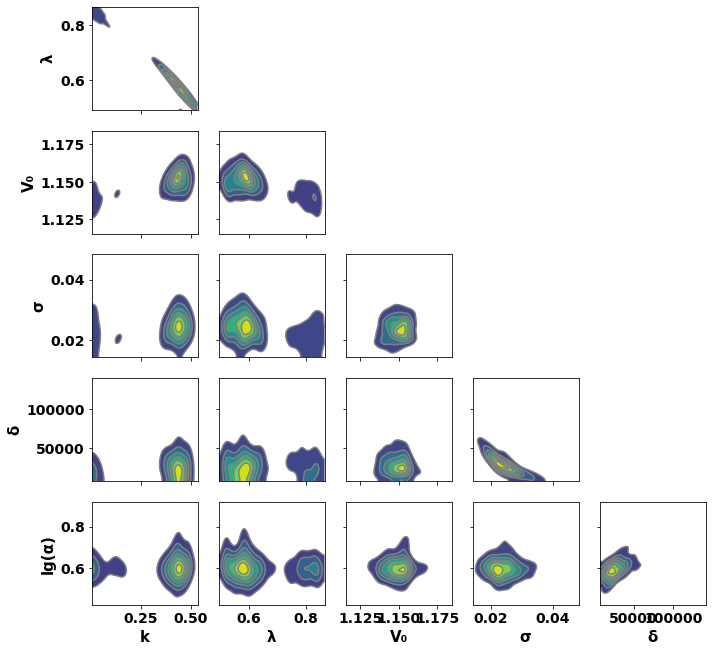

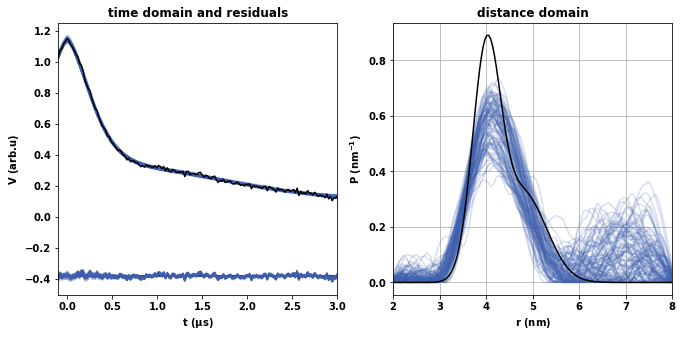

In [10]:
Ptrue = dl.dd_gauss2(r,pars['gaussians'])
dive.summary(trace, model, Vexp, t, r, Pref = Ptrue, GroundTruth = pars)  

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>SamplePfromV: [P]
>randDelta: [delta]
>NUTS: [k, V0, lamb, sigma]
Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 636 seconds.
There were 722 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5054925192530645, but should be close to 0.8. Try to increase the number of tuning steps.
There were 219 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1271 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3693797380329512, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9242568169164352, but should be close to 0.8. Try to increase the 

mean         sd    hdi_3%    hdi_97%  mcse_mean   mcse_sd  \
k          0.159      0.142     0.000      0.456      0.048     0.035   
λ          0.769      0.096     0.541      0.869      0.032     0.024   
V₀         1.146      0.012     1.127      1.170      0.001     0.001   
σ          0.026      0.010     0.014      0.044      0.001     0.001   
δ      35685.045  28656.290  1422.780  79504.159   2818.662  1998.746   
lg(α)      0.612      0.099     0.420      0.791      0.013     0.010   

       ess_bulk  ess_tail  r_hat  
k          11.0      58.0   1.31  
λ          10.0      50.0   1.34  
V₀         62.0     137.0   1.07  
σ          50.0     163.0   1.08  
δ          79.0     150.0   1.07  
lg(α)     130.0      57.0   1.08

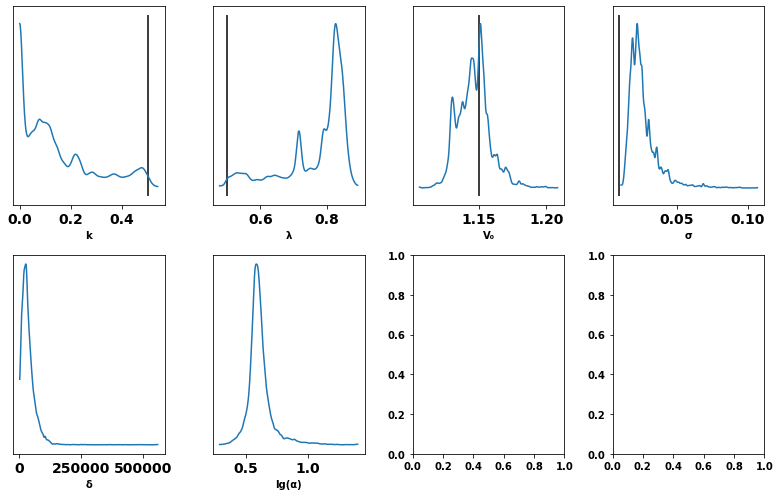

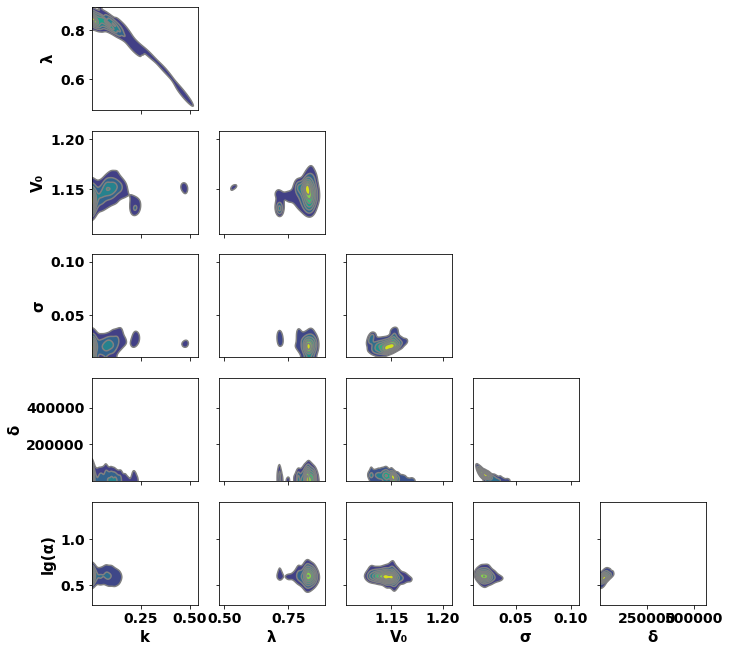

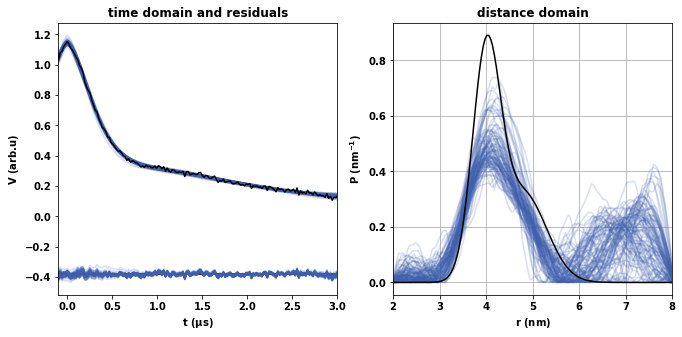

In [14]:
with model:
    step_P = dive.SamplePfromV(P, K0, LtL, t, Vexp, r, delta, sigma, k, lamb, V0)
    step_delta = dive.randDelta(delta, a0, b0, L, P)
    trace = pm.sample(step = [step_P, step_delta], chains=4, cores=4, draws=3000, tune= 1000, return_inferencedata=False, progressbar = False, init = {'P': fit.P})

Ptrue = dl.dd_gauss2(r,pars['gaussians'])
dive.summary(trace, model, Vexp, t, r, Pref = Ptrue, GroundTruth = pars)  

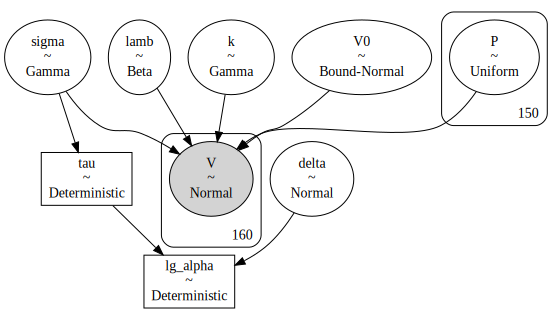

In [19]:
with pm.Model() as model:
    # Noise --------------------------------------------------------------
    sigma = pm.Gamma('sigma', alpha=0.7, beta=2)
    tau = pm.Deterministic('tau',1/(sigma**2))

    # Regularization parameter -------------------------------------------
    delta = pm.Normal('delta', mu = 20000, sigma = 10000)
    lg_alpha = pm.Deterministic('lg_alpha', np.log10(np.sqrt(delta/tau)) )
    
    # Time Domain --------------------------------------------------------
    lamb = pm.Beta('lamb', alpha=1.3, beta=2.0)
    V0 = pm.Bound(pm.Normal, lower=0.0)('V0', mu=1, sigma=0.2)

    # Background ---------------------------------------------------------
    k = pm.Gamma('k', alpha=0.5, beta=2)
    B = dl.bg_exp(t, k)

    # Distance distribution ----------------------------------------------
    # P = pm.MvNormal("P", mu = np.ones_like(r), tau = invSigma, shape = len(r))
    P = pm.Uniform("P", lower = 0, upper = 4, shape = len(r), transform=None)      

    # Calculate matrices and operators -----------------------------------
    Kintra = (1-lamb) + lamb*K0
    B_ = T.transpose( T.tile(B,(len(r),1)) )
    K = V0*Kintra*B_*dr
    # KtK = T.dot(T.transpose(K),K)
    # invSigma = tau*KtK + delta*LtL
    # invSigma = K0tK0 + LtL

    # Time domain model ---------------------------------------------------
    Vmodel = pm.math.dot(K,P)

    # Likelihood ----------------------------------------------------------
    pm.Normal('V',mu = Vmodel, sigma = sigma, observed = Vexp)

pm.model_to_graphviz(model) 

In [22]:
with model:
    step_P = dive.SamplePfromV(P, K0, LtL, t, Vexp, r, delta, sigma, k, lamb, V0)
    step_delta = dive.randDelta(delta, a0, b0, L, P)
    trace = pm.sample(step = [step_delta, step_P], chains=4, cores=4, draws=3000, tune= 1000, return_inferencedata=False, progressbar = False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>randDelta: [delta]
>SamplePfromV: [P]
>NUTS: [k, V0, lamb, sigma]


KeyboardInterrupt: 

mean         sd    hdi_3%    hdi_97%  mcse_mean   mcse_sd  \
k          0.189      0.145     0.000      0.429      0.057     0.042   
λ          0.750      0.087     0.584      0.871      0.030     0.022   
V₀         1.145      0.006     1.133      1.156      0.001     0.001   
σ          0.010      0.001     0.009      0.011      0.000     0.000   
δ      24147.466  15973.753  2817.351  52451.661   1544.953  1095.441   
lg(α)      0.146      0.156    -0.155      0.421      0.023     0.017   

       ess_bulk  ess_tail  r_hat  
k           7.0      25.0   1.55  
λ           8.0      36.0   1.40  
V₀         40.0     191.0   1.19  
σ          11.0      71.0   1.26  
δ          89.0     337.0   1.04  
lg(α)      44.0     193.0   1.07

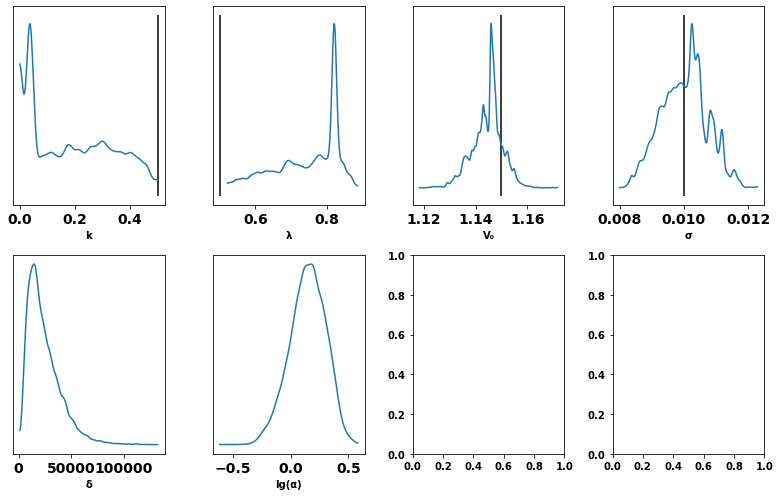

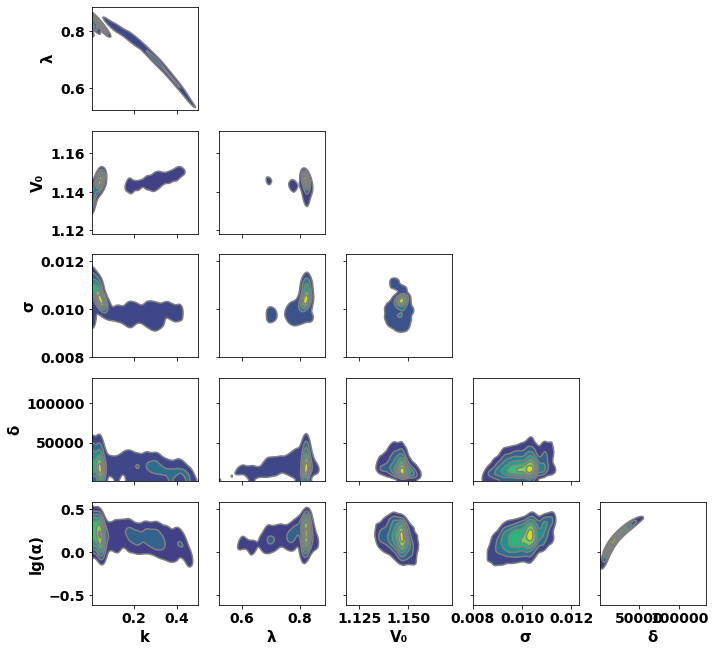

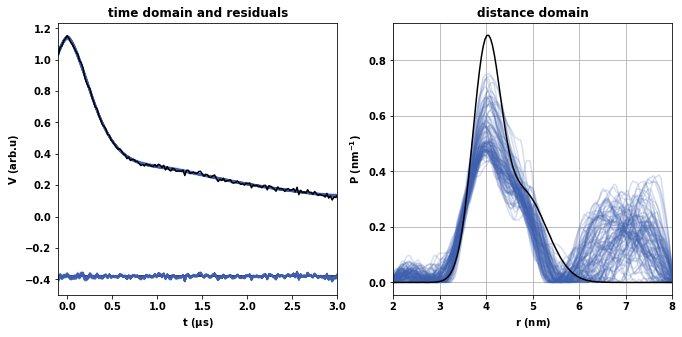

In [21]:
Ptrue = dl.dd_gauss2(r,pars['gaussians'])
dive.summary(trace, model, Vexp, t, r, Pref = Ptrue, GroundTruth = pars)  